# Performance Analysis

Here we optimize method hyperparameters on simulated examples and examine method accuracy and bias.

In [1]:
import pandas, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import re, os
from IPython.display import HTML, display
from tqdm import tqdm
from collections import defaultdict
import multiprocessing as mp
#mp.set_start_method("fork", force=True)

from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous, pi_cruise_control, lorenz_x
from pynumdiff.utils.evaluate import rmse, error_correlation
from pynumdiff.finite_difference import finitediff
from pynumdiff.smooth_finite_difference import kerneldiff, butterdiff
from pynumdiff.polynomial_fit import splinediff, polydiff, savgoldiff
from pynumdiff.basis_fit import spectraldiff, rbfdiff
from pynumdiff.total_variation_regularization import tvrdiff, smooth_acceleration
from pynumdiff.kalman_smooth import rtsdiff, robustdiff
from pynumdiff.optimize import optimize

Experimental search space parameters. There are many random seeds to ensure results are not flukes.

In [2]:
random_seeds = [1, 7, 31, 45, 57, 101, 256, 343, 737, 1024, 10000]# 11 of these
random_seeds += [1000001 + i for i in range(22)] # 22 more
random_seeds += [2000001 + i for i in range(19)] # 19 more
print(len(random_seeds))
dts = [0.005, 0.01, 0.02, 0.04] #, 0.08]
noise_types = [('normal', [0, 0.1]), ('laplace', [0, 0.1]), ('uniform', [-0.2, 0.2])]
noise_scales = [0.5, 1, 2, 4]
cutoff_frequencies = [1, 2, 3, 4, 5] # high frequency of signal in the data.

52


In [3]:
methods = [(kerneldiff, 'KernelDiff'),
			(butterdiff, 'ButterDiff'),
			(finitediff, 'IteratedFD'),
			(polydiff, 'PolyDiff'),
			(savgoldiff, 'SavGolDiff'),
			(splinediff, 'SplineDiff'),
			(spectraldiff, 'SpectralDiff'),
			(rbfdiff, 'RBFDiff'),
			(tvrdiff, 'TVRDiff'),
			(smooth_acceleration, 'SmoothAccelTVR'),
			(rtsdiff, 'RTSDiff'),
			(robustdiff, 'RobustDiff')]
sims = [(pi_cruise_control, 'Cruise Control'),
		(sine, 'Sum of Sines'),
		(triangle, 'Triangles'),
		(pop_dyn, 'Logistic Growth'),
		(linear_autonomous, 'Linear Autonomous'),
		(lorenz_x, 'Lorenz First Dimension')]

## Experiment

In [4]:
def main_loop(dt, cutoff_frequency, noise_type, noise_params, noise_scale, outliers, random_seed):
	"""Create and save a dataframe of results over all methods for all sims, given a certain
	hyperparameterization."""	
	try: # short circuit if the file already exists, just read in and display
		res = pandas.read_csv(f"~/Desktop/results/{cutoff_frequency}_{dt}_{noise_type}_{noise_scale}_{outliers}_{random_seed}.csv",
							 index_col=0)
		print(".", end='')
	except FileNotFoundError:
		tvgamma = np.exp(-1.6*np.log(cutoff_frequency) -0.71*np.log(dt) - 5.1)
		res = pandas.DataFrame(index=[x[1] for x in methods], columns=[x[1] for x in sims])

		for sim,sname in tqdm(sims):
			x, x_truth, dxdt_truth = sim(duration=4, dt=dt, noise_type=noise_type,
										noise_parameters=noise_scale*np.array(noise_params),
										outliers=outliers, random_seed=random_seed)
		
			for method,mname in methods:
				#best_params, best_rmse = optimize(method, x, dt, dxdt_truth=dxdt_truth, metric='rmse')
				#best_params, best_ec = optimize(method, x, dt, dxdt_truth=dxdt_truth, metric='error_correlation')
				best_params, best_score = optimize(method, x, dt, tvgamma=tvgamma, parallel=False, huberM=(2 if outliers else 6),
						search_space_updates=({'order':{2,3}} if (method in [tvrdiff, robustdiff] and sim != triangle) else {})) # because convex-based with order 1 tends to hack the cost function
				x_hat, dxdt_hat = method(x, dt, **best_params)
	
				rmse_dxdt = rmse(dxdt_truth, dxdt_hat)
				ec = error_correlation(dxdt_truth, dxdt_hat)
				res.loc[mname, sname] = f"RMSE: {rmse_dxdt:.5g}<br/>R^2: {ec:.5g}"
	
		res.to_csv(f"~/Desktop/results/{cutoff_frequency}_{dt}_{noise_type}_{noise_scale}_{outliers}_{random_seed}.csv")

		display(HTML(res.style.set_caption(
			f"cutoff_frequency={cutoff_frequency}, dt={dt}, noise_type={noise_type}, noise_scale={noise_scale}, outliers={outliers}, random_seed={random_seed}").set_properties(
			**{'text-align': 'left'}).to_html(escape=False)))
	

The hypercube was getting too dang big, so take intentional slices to answer specific questions.

In [5]:
jobs = []
for random_seed in random_seeds:
	# Does dt matter? Vary dt, keeping everything else constant
	jobs += [{'dt':dt, 'cutoff_frequency':3, 'noise_type':'normal', 'noise_params':[0, 0.1],
				'noise_scale':1, 'outliers':False, 'random_seed':random_seed} for dt in dts]

	# Does noise type matter? Vary noise type, keeping everything else constant
	jobs += [{'dt':0.01, 'cutoff_frequency':3, 'noise_type':noise_type, 'noise_params':noise_params,
				'noise_scale':1, 'outliers':False, 'random_seed':random_seed} for noise_type,noise_params in noise_types
				if noise_type != 'normal']
	
	# Does noise scale matter? Vary noise scale, keeping everything else constant
	jobs += [{'dt':0.01, 'cutoff_frequency':3, 'noise_type':'normal', 'noise_params':[0, 0.1],
				'noise_scale':noise_scale, 'outliers':False, 'random_seed':random_seed} for noise_scale in noise_scales
				if noise_scale != 1]
	
	# Does the presence of outliers matter? Vary presence of outliers, keeping everything else constant
	jobs += [{'dt':0.01, 'cutoff_frequency':3, 'noise_type':'normal', 'noise_params':[0, 0.1],
				'noise_scale':1, 'outliers':outliers, 'random_seed':random_seed} for outliers in [True]]
	
	# Does the cutoff frequency matter? Vary cutoff, keeping everything else constant
	jobs += [{'dt':0.01, 'cutoff_frequency':cutoff_frequency, 'noise_type':'normal', 'noise_params':[0, 0.1],
				'noise_scale':1, 'outliers':False, 'random_seed':random_seed} for cutoff_frequency in cutoff_frequencies
				if cutoff_frequency != 3]

def run(kwargs): main_loop(**kwargs)
with mp.Pool() as pool: pool.map(run, jobs)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Plot Results

In [6]:
def plot_perf(indie, vals, error_bars_gaps):
	"""
	:param str indie: the name of the independent variable
	:param list vals: values for the independent variable
	:param error_bars_gaps: how much space to give for the central symbol
	"""
	fig, ax = plt.subplots(2, 1, figsize=(30, 12), sharex=True, gridspec_kw={'hspace': 0})

	markers = ['p', 'd', '*', '2', '+', 'x', 'o', '.', r'$\gamma$', r'$\tilde{\gamma}$', '^', 's']
	facecolors = ['none' if i not in [3,4,5,7] else None for i in range(len(markers))] # 'none makes transparent'
	sizes = [90, 80, 120, 120, 100, 70, 70, 70, 90, 170, 90, 70]
	cmap = plt.get_cmap('turbo', 6) # Assign a unique color for each simulation
	colors = [cmap(i) for i in range(6)]; colors[0] = 'purple'; colors[-1] = 'red'
	colors[2] = [x*0.8 for x in colors[2]]; colors[3] = mcolors.to_rgb('gold'); colors[3] = [x*0.9 for x in colors[3]]
	colors[4] = [min(1, x*1.2) for x in colors[4]]

	point = {'cutoff_frequency':3, # all slices go through here
		'dt':0.01, 'noise_type':'normal', 'noise_scale':1, 'outliers':False}
	
	all_res = defaultdict(list)
	for random_seed in random_seeds:
		for v in vals:
			try:
				point[indie] = v # replace value
				res = pandas.read_csv(
					f"~/Desktop/results/{point['cutoff_frequency']}_{point['dt']}_{point['noise_type']}_{
						point['noise_scale']}_{point['outliers']}_{random_seed}.csv",
					index_col=0)
	
				for sim,sname in sims:
					for method,mname in methods:
						# extract the numbers
						rmse, ec = map(float, re.search(r"RMSE:\s*([\d.e+-]+)<br/>R\^2:\s*([\d.e+-]+)", res.loc[mname, sname]).groups())
						all_res[(v, mname, sname)].append((rmse, ec))

			except FileNotFoundError:
				print(f"{point['cutoff_frequency']}_{point['dt']}_{point['noise_type']}_{
						point['noise_scale']}_{point['outliers']}_{random_seed}.csv not yet computed")

	for a,v in enumerate(vals):
		for j,(sim,sname) in enumerate(sims):
			for i,(method,mname) in enumerate(methods):				
				for k,perfs in enumerate(zip(*all_res[(v, mname, sname)])):
					mean_perf = np.mean(perfs) # sample mean
					std_perf = np.std(perfs, ddof=1) # sample standard deviation
					#ci_perf = t_crit = t_dist.ppf(1 - 0.05/2, len(perfs)-1) * std_perf / np.sqrt(len(perfs)) # 95% confidence interval
					x = a*(len(sims)+0.2) + j + 0.05 + 0.9*i/len(methods)
					ax[k].scatter(x, mean_perf, color=colors[j], marker=markers[i], s=sizes[i],
								facecolor=facecolors[i], linewidth=1.5, label=mname if a==0 and a==0 and j==0 and k==0 else None) # label only once per method
					ax[k].vlines(x, mean_perf - std_perf, mean_perf - error_bars_gaps[k], color=colors[j], linewidth=1.5)
					ax[k].vlines(x, mean_perf + error_bars_gaps[k], mean_perf + std_perf, color=colors[j], linewidth=1.5)
					#ax[k].scatter((x, x), (mean_perf - ci_perf, mean_perf + ci_perf), color=colors[j], marker='_', s=20, linewidth=1.5)

	for k in range(2):
		for b in range(len(vals)-1):
			ax[k].axvline((len(sims)+0.2)*(b+1)-0.1, color="gray", linestyle="--", alpha=0.5)
		ax[k].tick_params(axis="x", length=0, labelsize=25) # length=0 hides tick lines
		ax[k].set_xlim(-0.1, len(vals)*(len(sims) + 0.2) - 0.1)
		ax[k].tick_params(axis='y', labelsize=18)
		ax[k].set_ylabel([r'RMSE($\mathbf{\hat{\dot{x}}}$, $\mathbf{\dot{x}}$)', r'Corr($\mathbf{\hat{\dot{x}}} - \mathbf{\dot{x}}$, $\mathbf{\dot{x}}$)'][k], fontsize=25)
	ax[0].set_xticklabels([])
	for label in ax[1].get_yticklabels(): label.set_fontstyle('italic')
	ax[0].set_ylim(0, 3)
	ax[1].set_ylim(0, 0.3)
	ax[1].set_xticks([(len(sims)+0.2)*(b+1)-(len(sims)+0.2)/2 - 0.1/2 for b in range(len(vals))]) 
	
	legend1 = ax[0].legend(ncol=2, columnspacing=0.5, handletextpad=0, loc='upper left', fontsize=15)
	ax[0].add_artist(legend1)
	for handle in legend1.legend_handles:
		handle.set_edgecolor('dimgray')
		if len(handle.get_facecolor()) == 1: handle.set_facecolor('dimgray') # for those that are filled
	sim_patches = [mpatches.Patch(color=colors[j], label=sname) for j,(sim,sname) in enumerate(sims)]
	legend2 = ax[0].legend(handles=sim_patches, loc='upper left', fontsize=15, bbox_to_anchor=(0.175, 1.0))

	return fig, ax


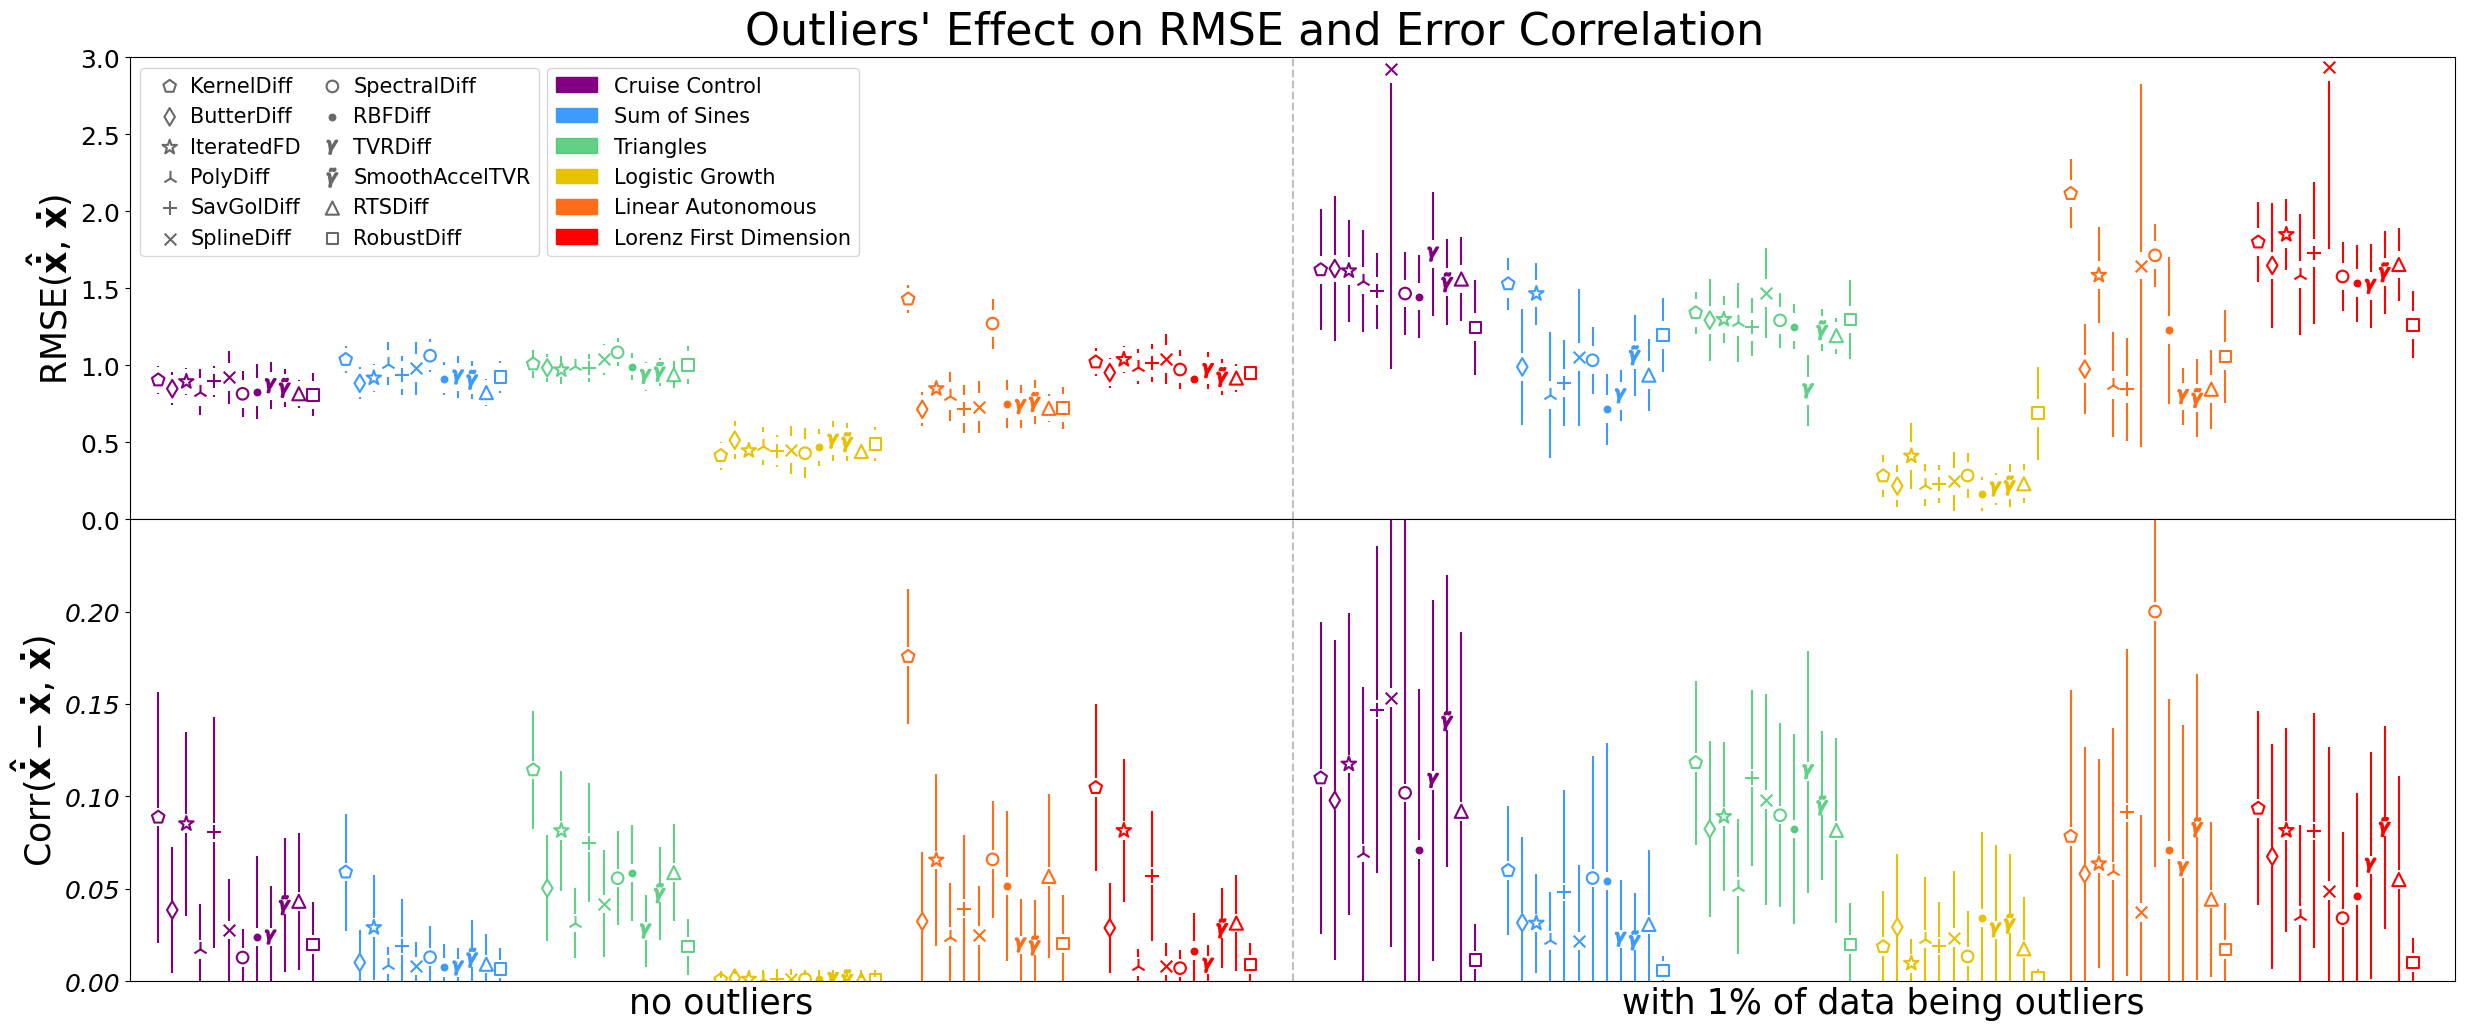

In [12]:
fig, ax = plot_perf('outliers', [False, True], (0.09, 0.005))
ax[0].set_ylim(0, 3)
ax[1].set_ylim(0, 0.25)
ax[1].set_yticks(ax[1].get_yticks()[:-1])
ax[1].set_xticklabels(["no outliers", "with 1% of data being outliers"])
fig.suptitle(r"Outliers' Effect on RMSE and Error Correlation", fontsize=32, y=0.92)
fig.savefig(os.path.expanduser("~/Desktop/vary_outliers.png"), bbox_inches='tight')

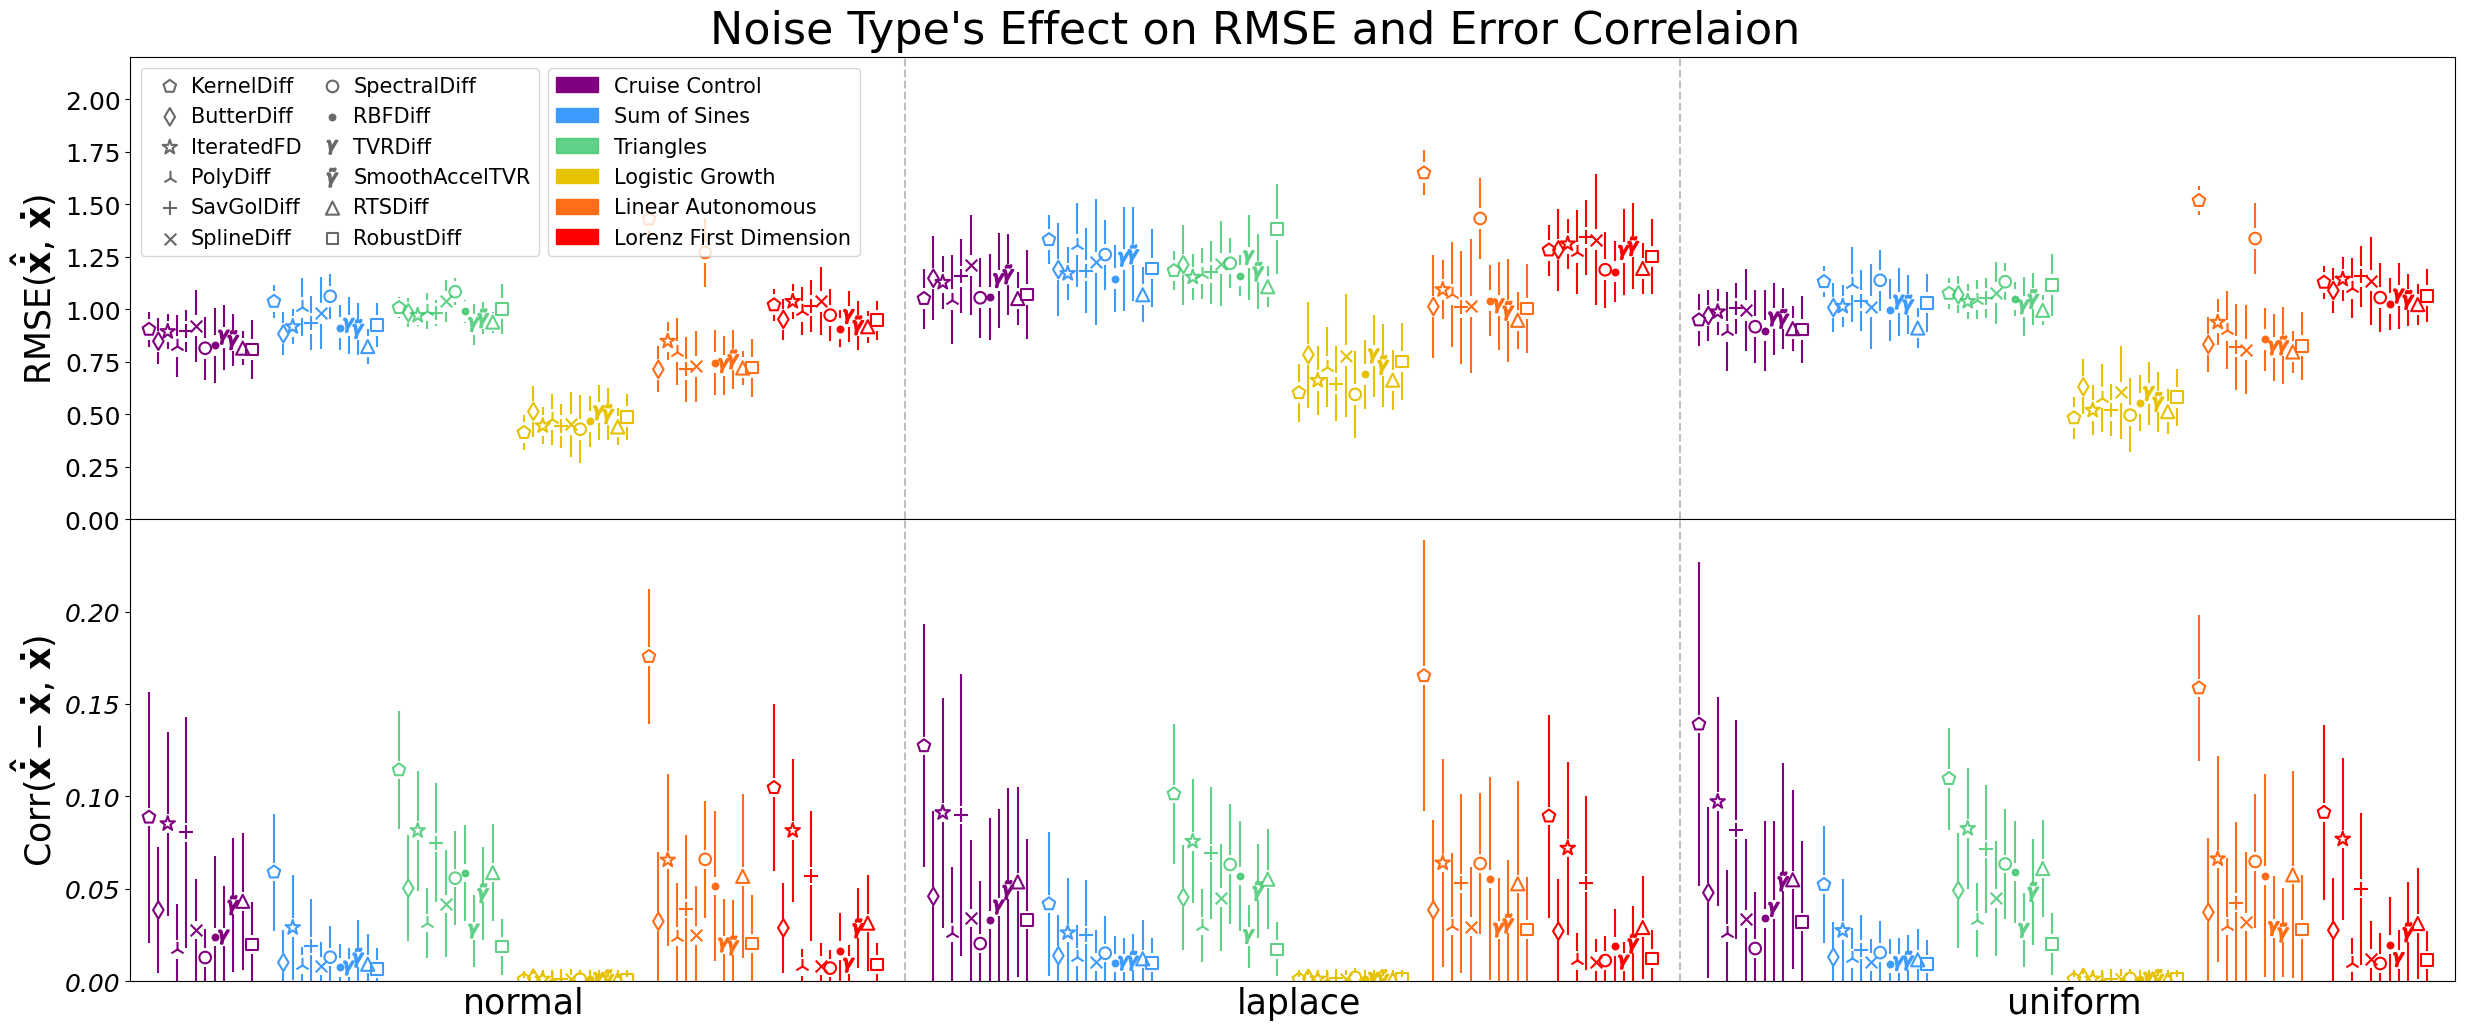

In [8]:
fig, ax = plot_perf('noise_type', [x[0] for x in noise_types], (0.05, 0.005))
ax[0].set_ylim(0, 2.2)
ax[1].set_ylim(0, 0.25)
ax[1].set_yticks(ax[1].get_yticks()[:-1])
ax[1].set_xticklabels([rf"{x[0]}" for x in noise_types])
fig.suptitle(r"Noise Type's Effect on RMSE and Error Correlaion", fontsize=32, y=0.92)
fig.savefig(os.path.expanduser("~/Desktop/vary_noise_type.png"), bbox_inches='tight')

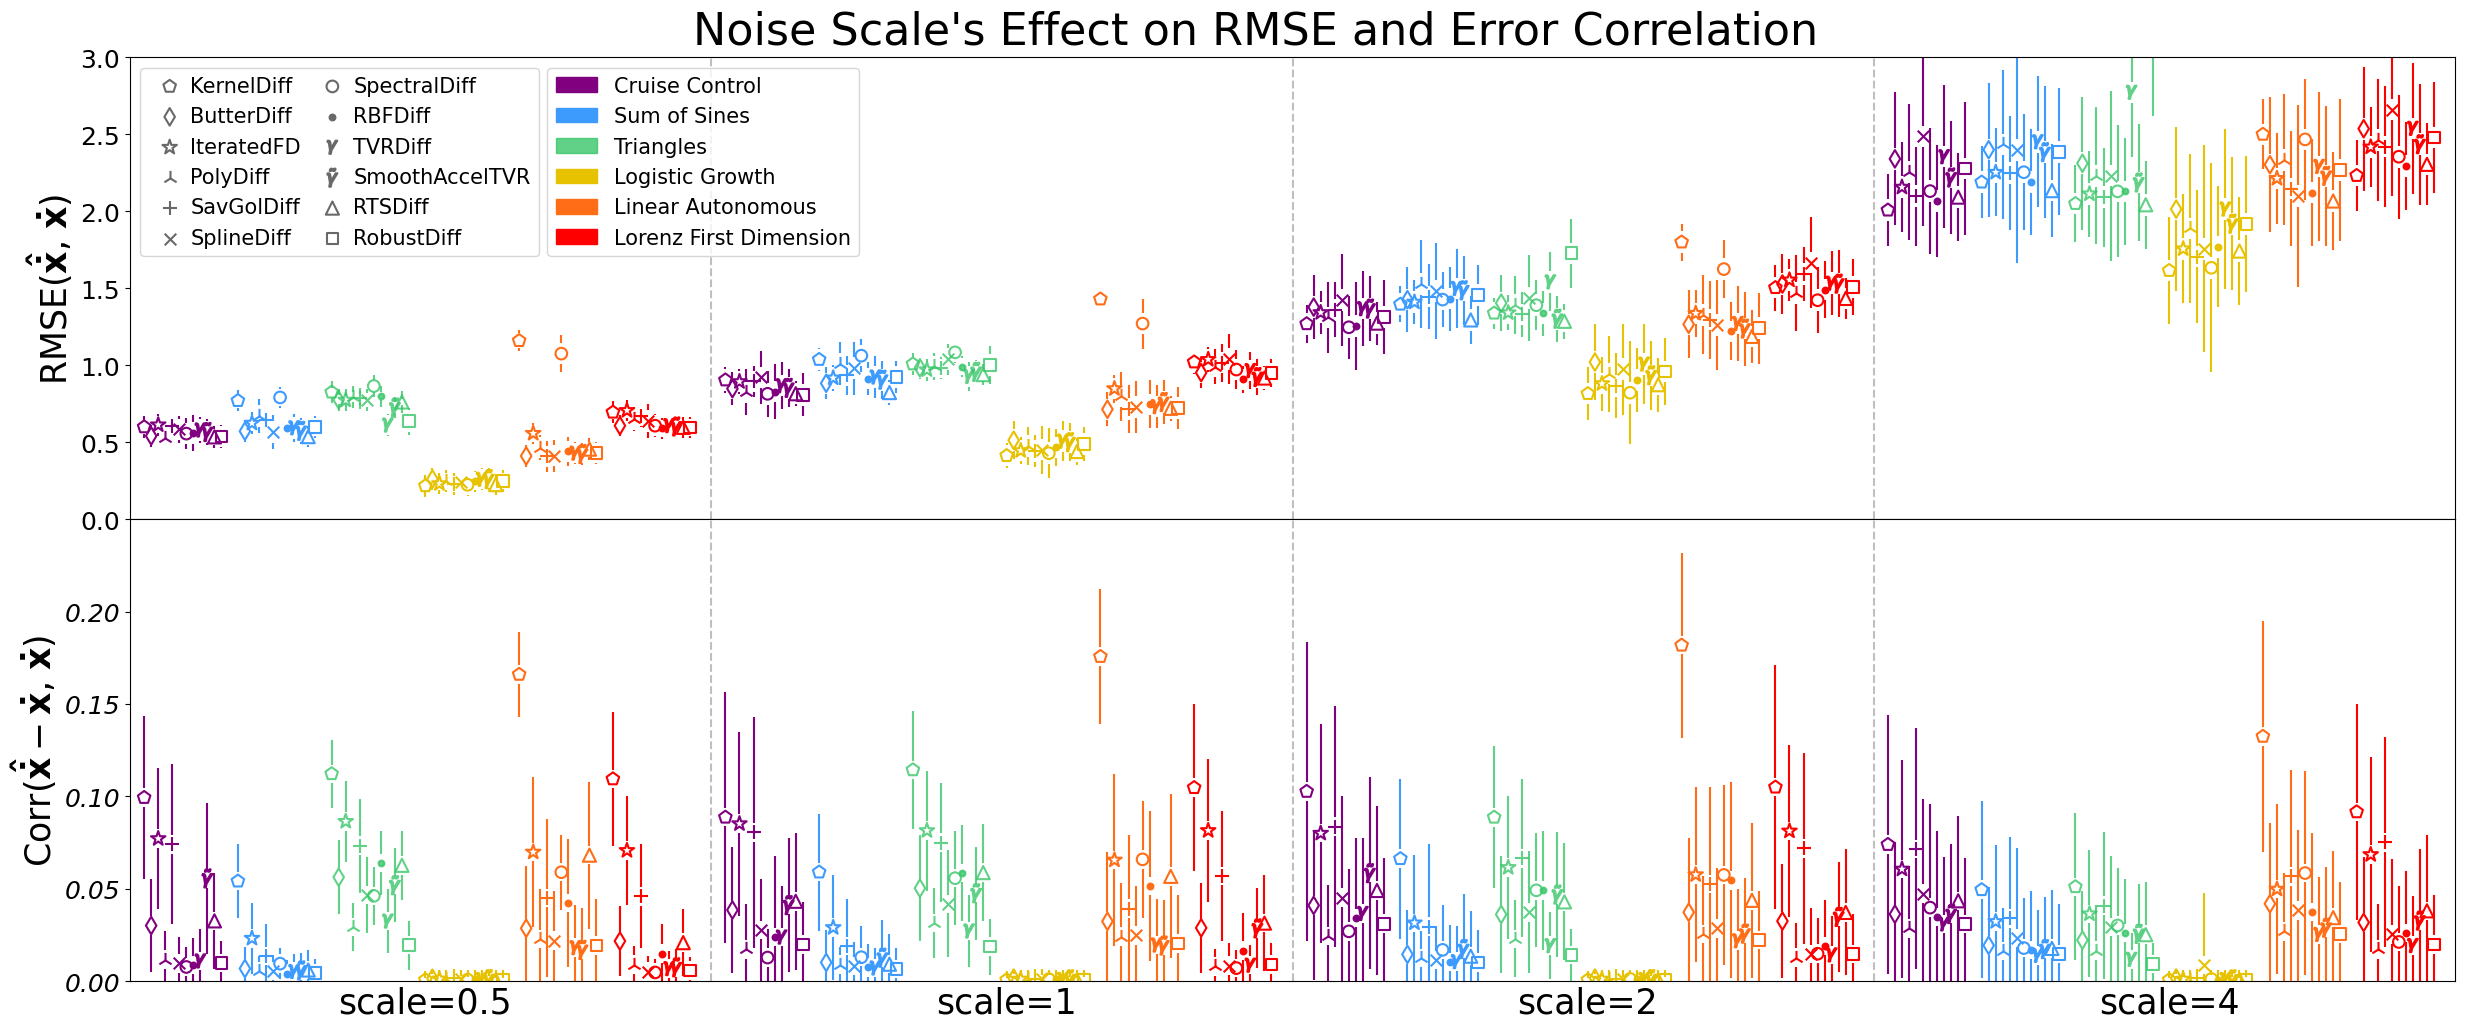

In [9]:
fig, ax = plot_perf('noise_scale', noise_scales, (0.07, 0.005))
ax[0].set_ylim(0, 3)
ax[1].set_ylim(0, 0.25)
ax[1].set_yticks(ax[1].get_yticks()[:-1])
ax[1].set_xticklabels([rf"scale={x}" for x in noise_scales])
fig.suptitle(r"Noise Scale's Effect on RMSE and Error Correlation", fontsize=32, y=0.92)
fig.savefig(os.path.expanduser("~/Desktop/vary_noise_scale.png"), bbox_inches='tight')

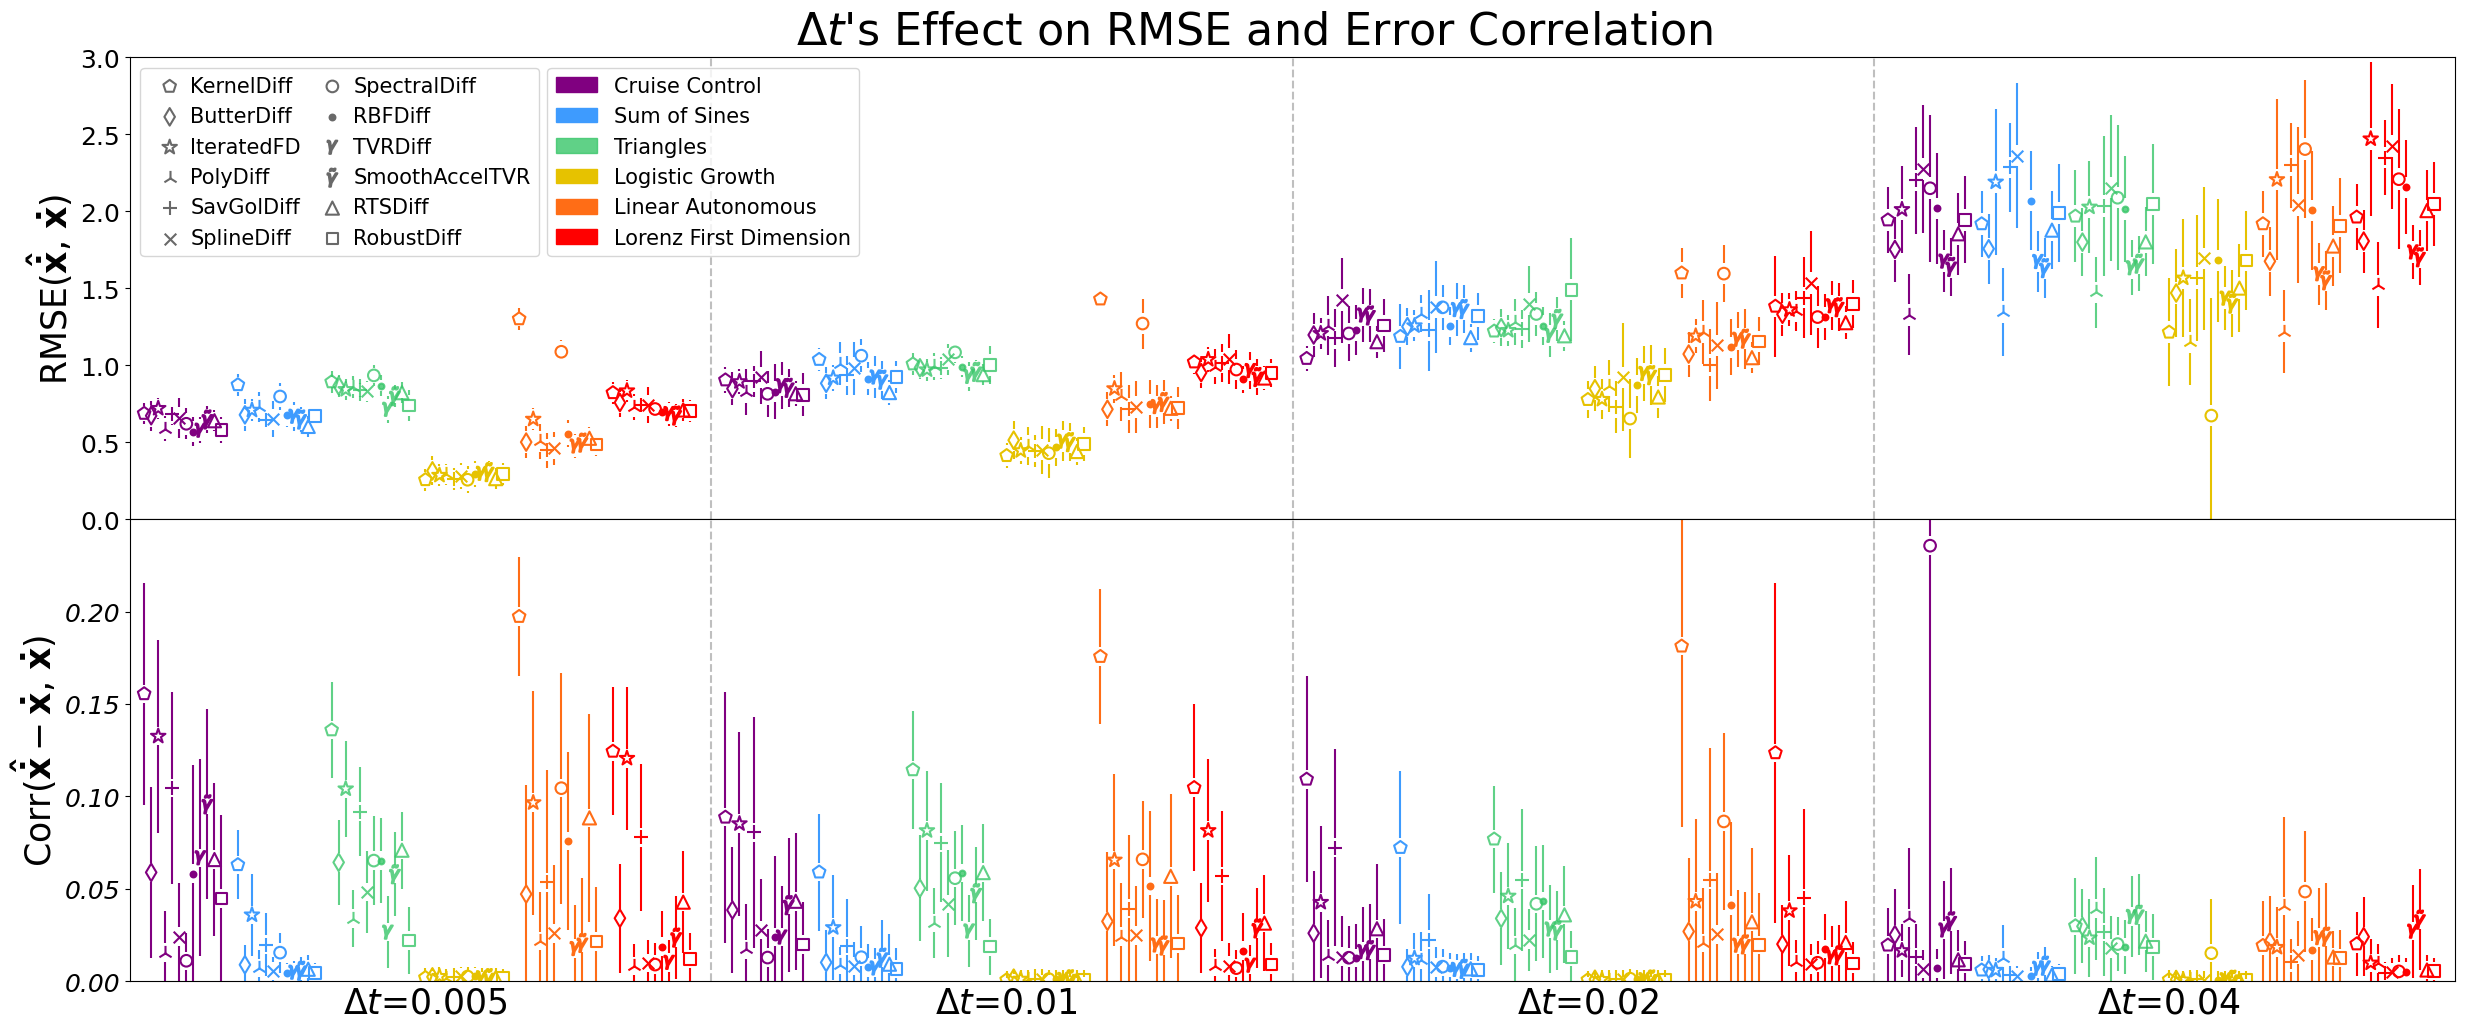

In [10]:
fig, ax = plot_perf('dt', dts, (0.07, 0.005))
ax[1].set_xticklabels([rf"$\Delta t$={dt}" for dt in dts])
ax[1].set_ylim(0, 0.25)
ax[1].set_yticks(ax[1].get_yticks()[:-1])
fig.suptitle(r"$\Delta t$'s Effect on RMSE and Error Correlation", fontsize=32, y=0.92)
fig.savefig(os.path.expanduser("~/Desktop/vary_dt.png"), bbox_inches='tight')

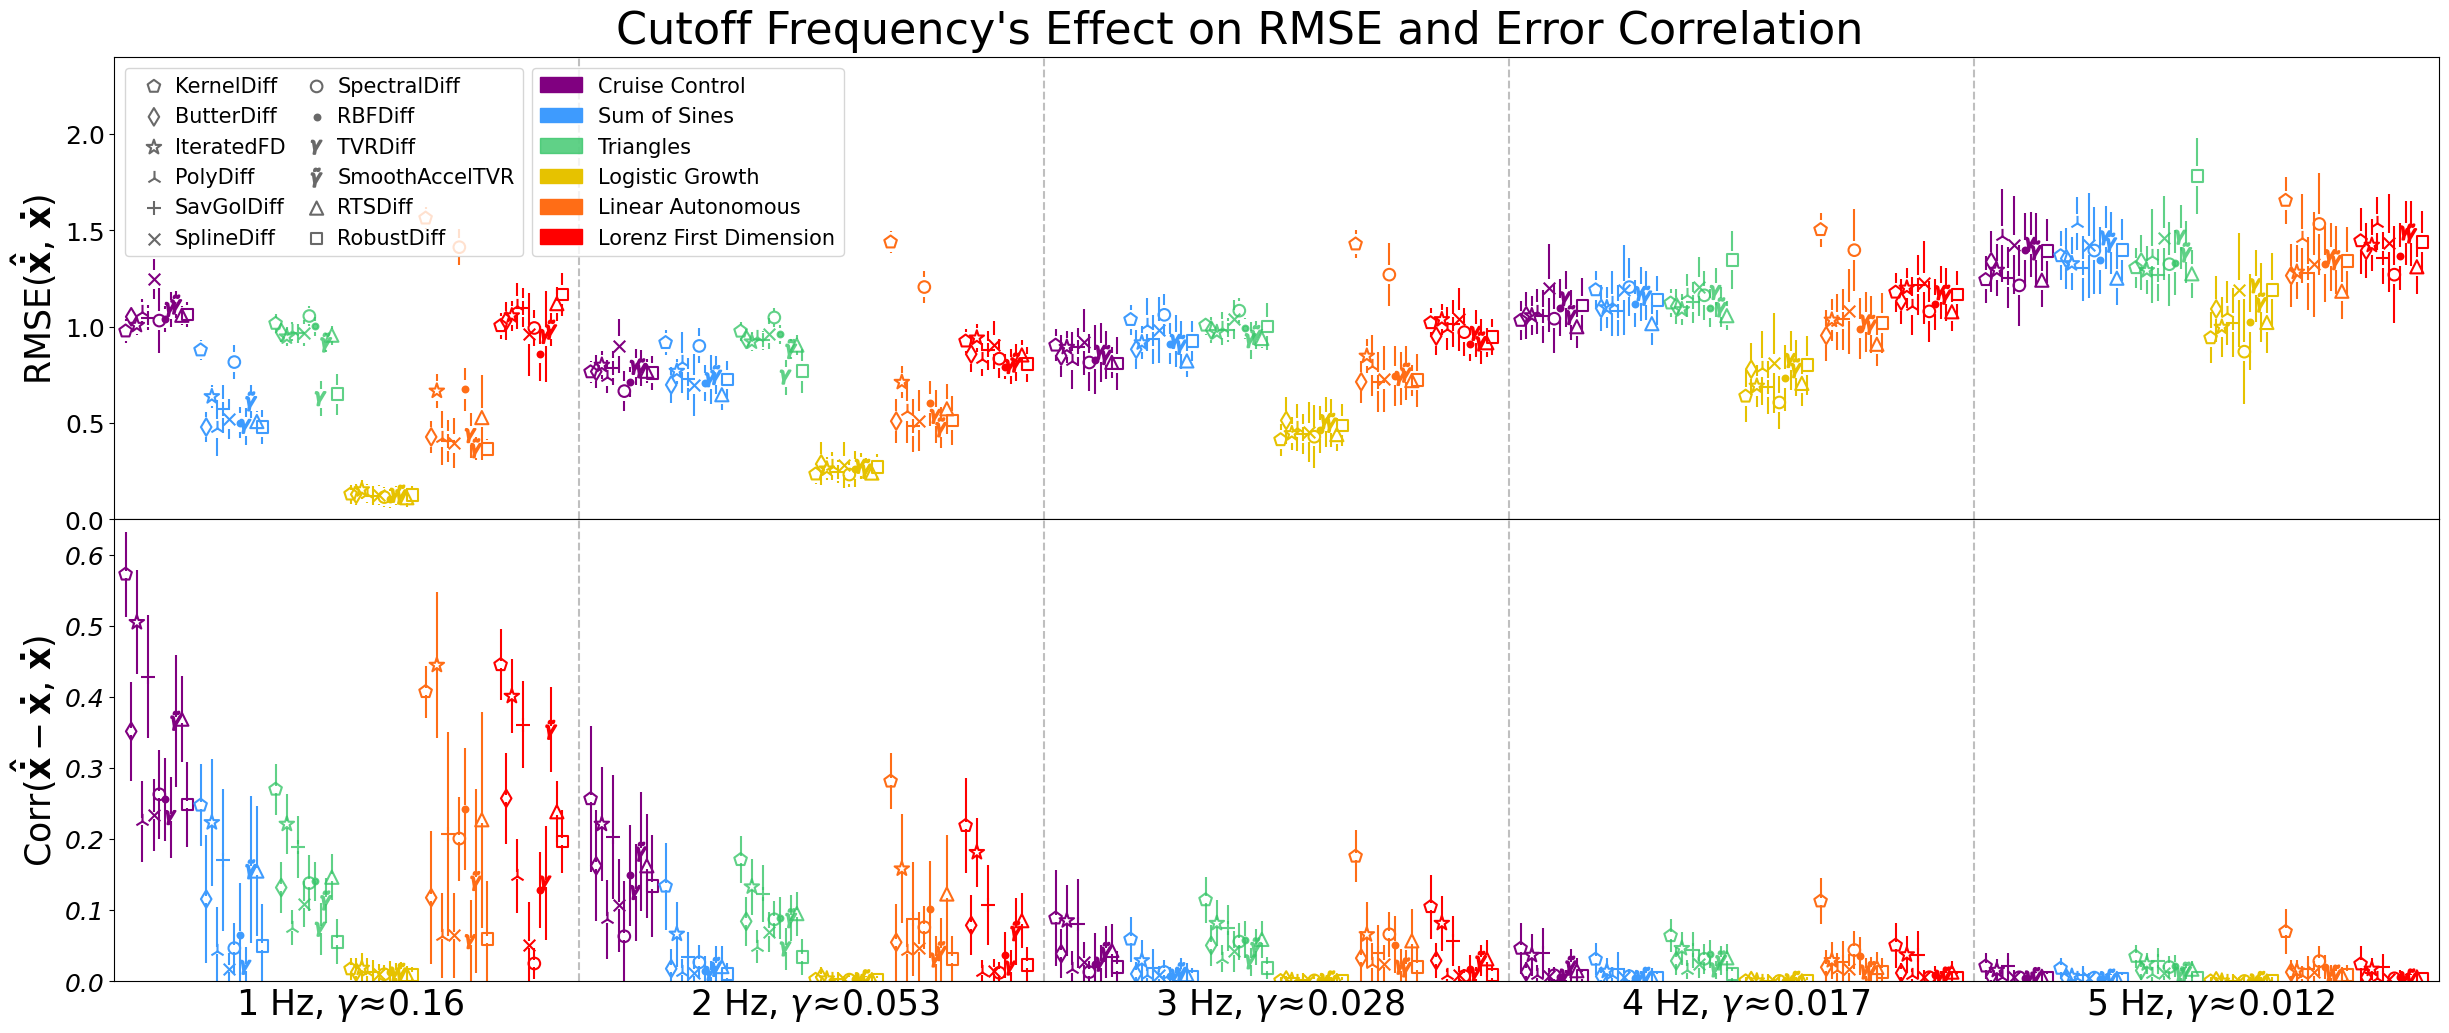

In [11]:
fig, ax = plot_perf('cutoff_frequency', cutoff_frequencies, (0.05, 0.005))
ax[0].set_ylim(0, 2.4)
ax[1].set_ylim(0, 0.65)
ax[1].set_xticklabels([rf"{f} Hz, $\gamma\!\approx\!${np.exp(-1.6*np.log(f) - 0.71*np.log(0.01) - 5.1):.2g}" for f in cutoff_frequencies])
fig.suptitle(r"Cutoff Frequency's Effect on RMSE and Error Correlation", fontsize=32, y=0.92)
fig.savefig(os.path.expanduser("~/Desktop/vary_f.png"), bbox_inches='tight')